# Summary

Recently (possibly since upgrading to openai 0.18.1?), querying openai causes invalid URL errors. Here are some notes from yesterday's troubleshooting session.

- curl works, python doesn't.
- Not just codex, now nox openai engines work w/ python. Maybe due to updating pip package? Temporarily upped billing limit to try other models.
- Restarted kernel and gpt query works again w/ ada. BUT after I import openai explicitly, that fails too. That must be a clue.
- Tried uninstalling, reinstalling, opened new tmux pane. Still same error.
- Tried deleting 'openai' object and then importing jabberwocky. This does work!?
- If I re-import openai after that, GPT.query still works. But openai.completion while codex does not.
- If I import openai FROM jabberwocky openai_utils, codex query still fails. But GPT.query works. And openai.Completion works w/ engine ada!
- Conclusion: maybe it is codex-specific then?

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [786]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns

from jabberwocky.config import C
from htools import *

In [3]:
cd_root()

Current directory: /Users/hmamin/jabberwocky


In [4]:
j_kwargs = {'prompt': 'a', 'max_tokens': 1, 'engine_i': 0}
ada_kwargs = {'prompt': 'a', 'max_tokens': 1, 'engine': 'text-ada-001'}
code_kwargs = {'prompt': 'a', 'max_tokens': 1, 'engine': 'code-davinci-001'}

## Jabberwocky

In [5]:
from jabberwocky.openai_utils import load_prompt, load_openai_api_key, \
    GPTBackend
import jabberwocky.openai_utils as oautils

Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_stream_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/gooseai_sample_responses.pkl.


In [7]:
res = GPT.query(**j_kwargs)

{'max_tokens': 1, 'engine_i': 0, 'prompt': 'a', 'meta': {'backend_name': 'openai', 'query_func': 'query_gpt3', 'datetime': 'Mon Apr 25 19:42:34 2022'}}


In [8]:
res

([''],
 [{'text': '\n',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'length',
   'prompt_index': 0}])

## openai 0.6.2

In [9]:
import openai

In [10]:
openai.version.VERSION

'0.18.1'

In [11]:
with open('/Users/hmamin/.openai', 'r') as f:
    openai.api_key = f.read().strip()

In [12]:
# oautils.openai == openai

In [13]:
res = openai.Completion.create(**code_kwargs)

In [14]:
res

<OpenAIObject text_completion id=cmpl-515RxlKh9094yUQFyFqI4pVMKtjrV at 0x11f6c0b48> JSON: {
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "text": "nt"
    }
  ],
  "created": 1650940961,
  "id": "cmpl-515RxlKh9094yUQFyFqI4pVMKtjrV",
  "model": "code-davinci:001",
  "object": "text_completion"
}

## openai 0.18.1

In [15]:
import openai

In [16]:
openai.version.VERSION

'0.18.1'

In [11]:
with open('/Users/hmamin/.openai', 'r') as f:
    openai.api_key = f.read().strip()

In [12]:
# oautils.openai == openai

In [13]:
res = openai.Completion.create(**code_kwargs)

In [14]:
res

<OpenAIObject text_completion id=cmpl-515ItOmu7H4oHPA2yyDXpfHpteeby at 0x1245a1bf8> JSON: {
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "text": ""
    }
  ],
  "created": 1650940399,
  "id": "cmpl-515ItOmu7H4oHPA2yyDXpfHpteeby",
  "model": "code-davinci:001",
  "object": "text_completion"
}

In [14]:
from jabberwocky.openai_utils import load_prompt, load_openai_api_key, \
    GPTBackend
import jabberwocky.openai_utils as oautils

Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_stream_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/gooseai_sample_responses.pkl.


In [16]:
res = GPT.query(**j_kwargs)

{'max_tokens': 1, 'engine_i': 0, 'prompt': 'a', 'meta': {'backend_name': 'openai', 'query_func': 'query_gpt3', 'datetime': 'Sun Apr 24 15:42:59 2022'}}


In [17]:
res

([''],
 [{'text': '\n',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'length',
   'prompt_index': 0}])

## Takeaways

Could not reproduce error with either old or new version of openai package. Maybe ipython handles things differently from jupyter?

Update: could not reproduce in ipython either. No new openai version has been released in the last few days so it's not like they fixed something. Maybe it was an autoreload thing?

## Stop words in streaming mode

In [1463]:
from collections import deque
from transformers import GPT2Tokenizer, GPT2TokenizerFast

In [1468]:
text = """
Leverage agile frameworks to provide a robust synopsis for high level overviews. Iterative approaches to corporate strategy foster collaborative thinking to further the overall value proposition. Organically grow the holistic world view of disruptive innovation via workplace diversity and empowerment.

Bring to the table win-win survival strategies to ensure proactive domination. At the end of the day, going forward, a new normal that has evolved from generation X is on the runway heading towards a streamlined cloud solution. User generated content in real-time will have multiple touchpoints for offshoring.

Capitalize on low hanging fruit to identify a ballpark value added activity to beta test. Override the digital divide with additional clickthroughs from DevOps. Nanotechnology immersion along the information highway will close the loop on focusing solely on the bottom line.
"""

In [1475]:
fast_tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

In [1474]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [1470]:
len(fast_tokenizer.tokenize(text)), len(tokenizer.tokenize(text))

(165, 165)

In [1473]:
%timeit _ = fast_tokenizer.tokenize(text)
%timeit _ = tokenizer.tokenize(text)

767 µs ± 113 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
860 µs ± 104 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [100]:
tokenizer_j = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-j-6B')

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [199]:
list(tokenizer.get_vocab().items())[-5:]

[('Ġregress', 50252),
 ('ĠCollider', 50253),
 ('Ġinformants', 50254),
 ('Ġgazed', 50255),
 ('<|endoftext|>', 50256)]

In [119]:
tokenizer.tokenize('Sylvia: Hi.\n\nMe: Hello<END>')

['S',
 'yl',
 'via',
 ':',
 'ĠHi',
 '.',
 'Ċ',
 'Ċ',
 'Me',
 ':',
 'ĠHello',
 '<',
 'END',
 '>']

In [200]:
tokenizer.tokenize('Sylvia: Hi.\n\nMe: Hello<|endoftext|>')

['S',
 'yl',
 'via',
 ':',
 'ĠHi',
 '.',
 'Ċ',
 'Ċ',
 'Me',
 ':',
 'ĠHello',
 '<|endoftext|>']

In [120]:
tokenizer_j.tokenize('Sylvia: Hi.\n\nMe: Hello<END>')

['S',
 'yl',
 'via',
 ':',
 'ĠHi',
 '.',
 'Ċ',
 'Ċ',
 'Me',
 ':',
 'ĠHello',
 '<',
 'END',
 '>']

In [18]:
GPT.switch('mock')

Switching openai backend to "mock".


In [19]:
for tok, full in GPT.query('This is the last time', stream=True):
    print(tok)
    print(full)
    print(spacer())

{'stream': True, 'prompt': 'This is the last time', 'meta': {'backend_name': 'mock', 'query_func': 'query_gpt_mock', 'datetime': 'Mon Apr 25 19:42:57 2022'}}
 a
{'finish_reason': None, 'index': 0, 'logprobs': <OpenAIObject at 0x11f6b3db0> JSON: {
  "text_offset": [
    0
  ],
  "token_logprobs": [
    -1.3818359375
  ],
  "tokens": [
    " a"
  ],
  "top_logprobs": [
    {
      " a": -1.3818359375,
      " my": -2.384765625,
      " the": -1.8720703125
    }
  ]
}, 'text': ' a', 'token_index': 0, 'prompt_index': 0}

-------------------------------------------------------------------------------

 bit
{'finish_reason': None, 'index': 0, 'logprobs': <OpenAIObject at 0x11f6b3f68> JSON: {
  "text_offset": [
    2
  ],
  "token_logprobs": [
    -4.75390625
  ],
  "tokens": [
    " bit"
  ],
  "top_logprobs": [
    {
      " big": -1.83984375,
      " day": -2.53125,
      " very": -2.916015625
    }
  ]
}, 'text': ' bit', 'token_index': 1, 'prompt_index': 0}

------------------------------

/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:721: UserWarning: strip_output=True is not supported in stream mode. Automatically setting it to False.
  warnings.warn('strip_output=True is not supported in stream '
/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:726: UserWarning: Streaming mode does not support manual truncation of stop phrases and your current backend has limited support for truncation.
  'Streaming mode does not support manual truncation of '


In [20]:
conv = oautils.ConversationManager(verbose=False)
conv

In [90]:
GPT.switch('openai')
with conv.converse('Sylvia Plath'):
    res = conv.query('Hi.', engine_i=0,
                     stream=True, max_tokens=25)

Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_stream_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/gooseai_sample_responses.pkl.
Switching openai backend to "openai".
{'engine_i': 0, 'temperature': 0.5, 'max_tokens': 25, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'stream': True, 'prompt': 'This is a conversation with Sylvia Plath. Sylvia Plath (October 27, 1932 - February 11, 1963) was an American poet, novelist, and short-story writer. She is credited with advancing the genre of confessional poetry and is best known for two of her published collections, The Colossus and Other Poems (1960) and Ariel (1965), as well as The Bell Jar, a semi-autobiographical novel published shortly before her death in 1963.\n\nMe: Hi.\n\nSylvia Plath:', 'meta': {'backend_name': 'openai', 'query_func': 'query_gpt3', 'datetime': 'Mon Apr 25 20:25:41 2022'}}


In [91]:
res2 = list(res)

In [92]:
[row[0] for row in res2]

[' Hi', '.', ' How', ' are', ' you', '?', '']

In [1156]:
res = [(' Hi',
  {'text': ' Hi',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 ('.',
  {'text': '.',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 (' How',
  {'text': ' How',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 (' are',
  {'text': ' are',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 (' you',
  {'text': ' you',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 ('?',
  {'text': '?',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 ('',
  {'text': '',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
('<|endoftext|>',
  {'text': '<|endoftext|>',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
(' ',
 {'text': ' ',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 ('Hey',
 {'text': 'Hey',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
  (' there',
 {'text': ' there',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'length',
   'prompt_index': 0}),
]

In [1131]:
res_2 = [(' Hi',
  {'text': ' Hi',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 ('.',
  {'text': '.',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 (' How',
  {'text': ' How',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 (' are',
  {'text': ' are',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 (' you',
  {'text': ' you',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 ('?',
  {'text': '?',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
('\n',
  {'text': '\n',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
('\n',
  {'text': '\n',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
('Me',
  {'text': 'Me',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
(':',
  {'text': ':',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
(' ',
 {'text': ' ',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
 ('Hey',
 {'text': 'Hey',
   'index': 0,
   'logprobs': None,
   'finish_reason': None,
   'prompt_index': 0}),
  (' there',
 {'text': ' there',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'length',
   'prompt_index': 0}),
]

In [1490]:
class StopWordStreamer:
    """Stream results from a GPT backend that supports streaming but either
    does not support stop word truncation OR supports it but keeps the actual
    stop word in the completion. At the moment, this only describes gooseai:
    openai truncates right before the stopword which is what I want, and
    huggingface/banana/vicgalle backends don't support streaming.

    A streamer object can be used with multiple completions (n>1) but it MUST
    be used for a single prompt (i.e. not a list of prompts).
    _stream_gooseai_generator therefore must create k streamer instances for
    each query, where k is the number of strings in the input prompt.
    """

    def __init__(self, stop_words=None, tokenizer=None, trie=None,
                 max_len=None, n=1):
        """We recommend using one of the factory constructors
        (from_trie or from_stopwords). _stream_gooseai_generator uses from_trie
        to avoid having to construct k separate tries for a query with k
        prompts.

        Either specify (stop_words and tokenizer) or (trie and max_len).

        Parameters
        ----------
        stop_words: None or list[str]
        tokenizer: None or transformers.GPT2Tokenizer
        trie: None or htools.Trie
            Trie built on a list of lists of strings. Each nested list
            corresponds to 1 stopword and each string within it corresponds to
            one of its "pretty" tokens (the tokenized form fed to the model is
            the result of BPE which creates a base vocab of 256 unicode chars
            corresponding to 256 bytes (2^8). This means there are some funny
            looking characters, e.g. "\n" maps to 'Ċ'. Completions are mapped
            back to the original characters, which is what we want to deal with
            since we'll be streaming completions). If you are creating many
            streamer objects, we suggest using the StopWordStreamer.create_trie
            to create 1 trie (and get max_len) and then using the from_trie
            constructor to create all the streamers.
        max_len: None or int
            Number of tokens in longest stopword when tokenized by GPT2.
        n: int
            Number of completions we asked to generate (same as n in
            GPT.query).

        Examples
        --------
        # For a single str prompt:
        streamer = StopWordStreamer(['\n\nMe:', '\n\nBrandon Sanderson:'],
                                    gpt2_tokenizer)
        GPT.switch('gooseai')
        response = GPT.query(prompt_str, stream=True)
        for res, full in streamer.stream(response):
            print(res, full)
        """
        if stop_words and tokenizer:
            assert trie is None and max_len is None, \
                'Do not pass in trie or max_len when specifying stop_words ' \
                'and tokenizer.'
            trie, max_len = self.create_trie(stop_words, tokenizer)
        elif trie and max_len:
            assert stop_words is None and tokenizer is None, \
                'Do not pass in stop_words or tokenizer when trie and ' \
                'max_len are provided.'
        else:
            raise RuntimeError('You must either provide stop_words and '
                               'tokenizer OR trie and max_len.')

        self.trie = trie
        self.max_len = max_len
        self.nodes = [set([self.trie.head]) for _ in range(n)]
        self.q = [deque() for _ in range(n)]
        self.done = [False for _ in range(n)]
        self.n = n
        self.used = False

    @classmethod
    def from_trie(cls, trie, max_len, n=1):
        return cls(trie=trie, max_len=max_len, n=n)

    @classmethod
    def from_stopwords(cls, stop_words, tokenizer, n=1):
        return cls(stop_words=stop_words, tokenizer=tokenizer, n=n)

    @classmethod
    def create_trie(cls, stop_words, tokenizer):
        """
        Parameters
        ----------
        stop_words
        tokenizer

        Returns
        -------
        tuple[Trie, int]: First item is trie containing all
        pretty-tokenized stop_words. Second item is the length (in # of tokens)
        of the longest stop word.
        """
        if not stop_words:
            raise ValueError('No stop_words provided.')
            
        tokenized = [cls._pretty_tokenize(tokenizer, word)
                     for word in stop_words]
        max_len = max(len(toks) for toks in tokenized)
        trie = Trie(tokenized)
        return trie, max_len

    @staticmethod
    def _pretty_tokenize(tokenizer, text):
        """Tokenize text but keep all tokens in 'decoded' form. E.g. simply
        calling tokenizer.tokenize('\n\nMe:') will result in the tokens
        ['Ċ', 'Ċ', 'Me', ':'], but calling _pretty_tokenize('\n\nMe:')
        will result in the tokens ['\n', '\n', 'Me', ':']. Since this class
        is used to filter gpt completions, we need to use the latter version.
        """
        return [tokenizer.decode(tok) for tok in tokenizer.encode(text)]

    def _drop_last_n(self, token, i):
        # Check if the newest token continues any previously found partial
        # stopwords for completion i. If a full stop word has been found,
        # return a positive integer with the number of tokens that stop word
        # contains (i.e. the number to drop). If we haven't encountered a
        # terminal state in our trie, we return 0 (falsy) indicating that we
        # should not stop streaming yet.
        nodes = self.nodes[i]
        new_nodes = set([self.trie.head])
        for node in nodes:
            if node.stop_state:
                return node.depth
            if token in node.edges:
                new_nodes.add(node.edges[token])
        self.nodes[i] = new_nodes
        depths = [node.depth for node in self.nodes[i] if node.stop_state]
        return max(depths or [0])

    def stream_step(self, tok, full):
        """Stream 1 step (1 token). This basically allows us to execute
        self.stream() step by step, which is useful in the case where we have
        multiple prompts and thus multiple StopWordStreamer objects (as in
        _stream_gooseai_generator()).

        Parameters
        ----------
        tok: str
        full: dict

        Yields
        ------
        tuple[str, dict]: (token, full_response), just like in all our gpt
        stream functions/generators.
        """
        # Modulo n accounts for the case where we use this on a
        # query with multiple prompts. E.g. if we have 2 prompts, one of those
        # prompts will have completions that are not zero-indexed.
        i = full.get('index', 0) % self.n
        if self.done[i]: return
        q = self.q[i]
        to_drop = self._drop_last_n(tok, i)
        if to_drop:
            # Subtract 1 because we didn't add the latest token yet.
            for j in range(to_drop - 1):
                q.pop()
            if q: q[-1][-1]['finish_reason'] = 'stop'
            while q:
                yield q.popleft()
            self.done[i] = True
            return

        # Do not use tuple because we want this to be mutable to more
        # easily edit the finish_reason if necessary.
        q.append([tok, full])
        if len(q) > self.max_len:
            yield q.popleft()

    def stream_remaining(self):
        """After all tokens have been passed to self.stream_step(), we need to
        check and see if there are any remaining items in the queue that need
        to be streamed.

        Yields
        ------
        tuple[str, dict]: (token, full_response), just like in all our gpt
        stream functions/generators.
        """
        for i, (q, done) in enumerate(zip(self.q, self.done)):
            while q and not done:
                yield q.popleft()
            # Just update this to provide a sanity check. One we finish
            # streaming from this method, all should be done.
            self.done[i] = True

    def stream(self, gen):
        """Stream response from a call like GPT.query(prompt, stream=True).
        Note that this is built to work on a single prompt (not a list of
        multiple prompts) - that's why _stream_gooseai_generator() creates
        k streamers, where k is the number of prompts.

        Parameters
        ----------
        gen: generator
            Result of calling GPT.query(my_prompt, stream=True). At the moment
            this is only used when the gooseai backend is active since the
            other backends don't require as complex processing (gooseai is the
            only one that DOES support streaming mode but truncates AFTER
            stop words).

        Yields
        ------
        tuple[str, dict]: (token, full_response), just like in all our gpt
        stream functions/generators.
        """
        if self.used:
            raise RuntimeError(
                f'This {type(self).__name__} has already been used. You '
                'should create a new instance. Stop words can vary by prompt '
                'and even by query (users can pass in additional stop words) '
                'so it doesn\'t make sense to reuse them.'
            )

        # We refactor the step into a separate method because
        # _stream_gooseai_generator() needs to create 1 StopWordStreamer
        # for each prompt in an input query, then call each one for a single
        # step at a time.
        for tok, full in gen:
            yield from self.stream_step(tok, full)
        yield from self.stream_remaining()
        self.used = True

In [1491]:
def _stream_gooseai_generator(gen, stop_words, tokenizer, n=1, np=1):
    if stop_words:
        trie, max_len = StopWordStreamer.create_trie(stop_words, tokenizer)
        streamers = [StopWordStreamer.from_trie(trie, max_len, n=n)
                     for _ in range(np)]
        for text, full in gen:
            full['prompt_index'] = full['index'] // n
            yield from streamers[full['prompt_index']].stream_step(text, full)

        for streamer in streamers:
            yield from streamer.stream_remaining()
    # Remember yields don't terminate functions like return, so this does 
    # require an explicit else block.
    else: 
        for text, full in gen:
            full['prompt_index'] = full['index'] // n
            yield text, full

In [1492]:
stop_words = ['tldr;', '\n\nMe:', '\n\nYou:', 'toast']

In [1484]:
# Streaming without filtering displays text after the stop word.
gen = (row for row in res_2)
for tok, full in gen:
    print(repr(tok))
    print('\t', full)

' Hi'
	 {'text': ' Hi', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'.'
	 {'text': '.', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' How'
	 {'text': ' How', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' are'
	 {'text': ' are', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' you'
	 {'text': ' you', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'?'
	 {'text': '?', 'index': 0, 'logprobs': None, 'finish_reason': 'stop', 'prompt_index': 0}
'\n'
	 {'text': '\n', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'\n'
	 {'text': '\n', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'Me'
	 {'text': 'Me', 'index': 0, 'logprobs': None, 'finish_reason': 'stop', 'prompt_index': 0}
':'
	 {'text': ':', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' '
	 {'text': ' ', 'index': 0, 'logprobs': None

In [1485]:
# WITH filtering truncates as desired.
gen = (row for row in res_2)
streamer = StopWordStreamer(stop_words, tokenizer)
for tok, full in streamer.stream(gen):
    print(repr(tok))
    print('\t', full)

' Hi'
	 {'text': ' Hi', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'.'
	 {'text': '.', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' How'
	 {'text': ' How', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' are'
	 {'text': ' are', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' you'
	 {'text': ' you', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'?'
	 {'text': '?', 'index': 0, 'logprobs': None, 'finish_reason': 'stop', 'prompt_index': 0}


In [1486]:
# WITH filtering truncates as desired.
gen = (row for row in res_2)
for tok, full in _stream_gooseai_generator(gen, stop_words, tokenizer):
    print(repr(tok))
    print('\t', full)

' Hi'
	 {'text': ' Hi', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'.'
	 {'text': '.', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' How'
	 {'text': ' How', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' are'
	 {'text': ' are', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' you'
	 {'text': ' you', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'?'
	 {'text': '?', 'index': 0, 'logprobs': None, 'finish_reason': 'stop', 'prompt_index': 0}


In [1488]:
# WITH filtering but WITHOUT passing in any stop_words.
gen = (row for row in res_2)
for tok, full in _stream_gooseai_generator(gen, stop_words=[], 
                                           tokenizer=tokenizer):
    print(repr(tok))
    print('\t', full)

' Hi'
	 {'text': ' Hi', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'.'
	 {'text': '.', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' How'
	 {'text': ' How', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' are'
	 {'text': ' are', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' you'
	 {'text': ' you', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'?'
	 {'text': '?', 'index': 0, 'logprobs': None, 'finish_reason': 'stop', 'prompt_index': 0}
'\n'
	 {'text': '\n', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'\n'
	 {'text': '\n', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'Me'
	 {'text': 'Me', 'index': 0, 'logprobs': None, 'finish_reason': 'stop', 'prompt_index': 0}
':'
	 {'text': ':', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' '
	 {'text': ' ', 'index': 0, 'logprobs': None

In [1453]:
# Use first res which does NOT contain a stop word.
gen = (row for row in res)
streamer = StopWordStreamer(stop_words, tokenizer)
for tok, full in streamer.stream(gen):
    print(repr(tok))
    print('\t', full)

' Hi'
	 {'text': ' Hi', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'.'
	 {'text': '.', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' How'
	 {'text': ' How', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' are'
	 {'text': ' are', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' you'
	 {'text': ' you', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'?'
	 {'text': '?', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
''
	 {'text': '', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'<|endoftext|>'
	 {'text': '<|endoftext|>', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' '
	 {'text': ' ', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'Hey'
	 {'text': 'Hey', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' there'
	 {'text': ' there', 'i

In [1454]:
# Use first res which does NOT contain a stop word.
gen = (row for row in res)
streamer = StopWordStreamer(stop_words, tokenizer)
for tok, full in streamer.stream(gen):
    print(repr(tok))
    print('\t', full)

' Hi'
	 {'text': ' Hi', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'.'
	 {'text': '.', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' How'
	 {'text': ' How', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' are'
	 {'text': ' are', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' you'
	 {'text': ' you', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'?'
	 {'text': '?', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
''
	 {'text': '', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'<|endoftext|>'
	 {'text': '<|endoftext|>', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' '
	 {'text': ' ', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'Hey'
	 {'text': 'Hey', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' there'
	 {'text': ' there', 'i

In [1455]:
# Use first res which does NOT contain a stop word.
gen = (row for row in res)
for tok, full in _stream_gooseai_generator(gen, stop_words, tokenizer):
    print(repr(tok))
    print('\t', full)

' Hi'
	 {'text': ' Hi', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'.'
	 {'text': '.', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' How'
	 {'text': ' How', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' are'
	 {'text': ' are', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' you'
	 {'text': ' you', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'?'
	 {'text': '?', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
''
	 {'text': '', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'<|endoftext|>'
	 {'text': '<|endoftext|>', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' '
	 {'text': ' ', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
'Hey'
	 {'text': 'Hey', 'index': 0, 'logprobs': None, 'finish_reason': None, 'prompt_index': 0}
' there'
	 {'text': ' there', 'i

In [1456]:
# NO filtering.
with GPT('mock'):
    gen = GPT.query('test', n=2, stream=True)
    print(spacer())
    for tok, full in gen:
        print(tok)
        print('\t', select(full, drop=['text', 'logprobs']))

Switching openai backend to "mock".
{'n': 2, 'stream': True, 'prompt': 'test', 'meta': {'backend_name': 'mock', 'query_func': 'query_gpt_mock', 'datetime': 'Sat May  7 14:03:35 2022'}}

-------------------------------------------------------------------------------

 a
	 {'finish_reason': None, 'index': 0, 'token_index': 0, 'prompt_index': 0}
 positive
	 {'finish_reason': None, 'index': 0, 'token_index': 1, 'prompt_index': 0}
 day
	 {'finish_reason': 'length', 'index': 0, 'token_index': 2, 'prompt_index': 0}
 clearer
	 {'finish_reason': None, 'index': 1, 'token_index': 0, 'prompt_index': 0}
 and
	 {'finish_reason': None, 'index': 1, 'token_index': 1, 'prompt_index': 0}
 colder
	 {'finish_reason': 'length', 'index': 1, 'token_index': 2, 'prompt_index': 0}
Switching  backend back to "banana".


/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:1079: UserWarning: strip_output=True is ignored in stream mode. Automatically setting it to False.
  warnings.warn('strip_output=True is ignored in stream '
/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:1111: UserWarning: Streaming mode does not support manual truncation of stop phrases and your current backend has limited support for truncation.
  'Streaming mode does not support manual truncation of '


In [1457]:
# WITH filtering. Single prompt, multiple completions.
n = 2
with GPT('mock'):
    gen = GPT.query('test', n=n, stream=True)
    print(spacer())
    for tok, full in _stream_gooseai_generator(gen, [' day'], tokenizer, n=n):
        print(repr(tok))
        print('\t', select(full, drop=['text', 'logprobs']))

Switching openai backend to "mock".
{'n': 2, 'stream': True, 'prompt': 'test', 'meta': {'backend_name': 'mock', 'query_func': 'query_gpt_mock', 'datetime': 'Sat May  7 14:03:46 2022'}}

-------------------------------------------------------------------------------

' a'
	 {'finish_reason': None, 'index': 0, 'token_index': 0, 'prompt_index': 0}
' positive'
	 {'finish_reason': 'stop', 'index': 0, 'token_index': 1, 'prompt_index': 0}
' clearer'
	 {'finish_reason': None, 'index': 1, 'token_index': 0, 'prompt_index': 0}
' and'
	 {'finish_reason': None, 'index': 1, 'token_index': 1, 'prompt_index': 0}
' colder'
	 {'finish_reason': 'length', 'index': 1, 'token_index': 2, 'prompt_index': 0}
Switching  backend back to "banana".


In [1458]:
# WITH filtering. Single prompt, multiple completions.
n = 2
streamer = StopWordStreamer([' day', ' and colder'], tokenizer, n=n)
with GPT('mock'):
    gen = GPT.query('test', n=n, stream=True)
    print(spacer())
    for tok, full in streamer.stream(gen):
        print(repr(tok))
        print('\t', select(full, drop=['text', 'logprobs']))

Switching openai backend to "mock".
{'n': 2, 'stream': True, 'prompt': 'test', 'meta': {'backend_name': 'mock', 'query_func': 'query_gpt_mock', 'datetime': 'Sat May  7 14:03:49 2022'}}

-------------------------------------------------------------------------------

' a'
	 {'finish_reason': None, 'index': 0, 'token_index': 0, 'prompt_index': 0}
' positive'
	 {'finish_reason': 'stop', 'index': 0, 'token_index': 1, 'prompt_index': 0}
' clearer'
	 {'finish_reason': 'stop', 'index': 1, 'token_index': 0, 'prompt_index': 0}
Switching  backend back to "banana".


In [1459]:
# WITH filtering. Single prompt, multiple completions.
n = 2
with GPT('mock'):
    gen = GPT.query('test', n=n, stream=True)
    print(spacer())
    for tok, full in _stream_gooseai_generator(
            gen, [' day', ' and colder'], tokenizer, n=n
    ):
        print(repr(tok))
        print('\t', select(full, drop=['text', 'logprobs']))

Switching openai backend to "mock".
{'n': 2, 'stream': True, 'prompt': 'test', 'meta': {'backend_name': 'mock', 'query_func': 'query_gpt_mock', 'datetime': 'Sat May  7 14:03:52 2022'}}

-------------------------------------------------------------------------------

' a'
	 {'finish_reason': None, 'index': 0, 'token_index': 0, 'prompt_index': 0}
' positive'
	 {'finish_reason': 'stop', 'index': 0, 'token_index': 1, 'prompt_index': 0}
' clearer'
	 {'finish_reason': 'stop', 'index': 1, 'token_index': 0, 'prompt_index': 0}
Switching  backend back to "banana".


In [1460]:
# WITHOUT filtering. Multiple prompts, multiple completions.
prompts = ['test', 'second']
np = len(prompts)
n = 2
with GPT('mock'):
    gen = GPT.query(prompts, n=n, stream=True)
    print(spacer())
    for tok, full in gen:
        print(repr(tok))
        print('\t', select(full, drop=['text', 'logprobs']))

Switching openai backend to "mock".
{'n': 2, 'stream': True, 'prompt': ['test', 'second'], 'meta': {'backend_name': 'mock', 'query_func': 'query_gpt_mock', 'datetime': 'Sat May  7 14:03:57 2022'}}

-------------------------------------------------------------------------------

' ways'
	 {'finish_reason': None, 'index': 2, 'token_index': 0, 'prompt_index': 1}
' are'
	 {'finish_reason': None, 'index': 2, 'token_index': 1, 'prompt_index': 1}
' there'
	 {'finish_reason': 'length', 'index': 2, 'token_index': 2, 'prompt_index': 1}
' a'
	 {'finish_reason': None, 'index': 0, 'token_index': 0, 'prompt_index': 0}
' grey'
	 {'finish_reason': None, 'index': 0, 'token_index': 1, 'prompt_index': 0}
' and'
	 {'finish_reason': 'length', 'index': 0, 'token_index': 2, 'prompt_index': 0}
' will'
	 {'finish_reason': None, 'index': 3, 'token_index': 0, 'prompt_index': 1}
' die'
	 {'finish_reason': None, 'index': 3, 'token_index': 1, 'prompt_index': 1}
'?'
	 {'finish_reason': 'length', 'index': 3, 'token_i

In [1461]:
# WITH filtering. Multiple prompts, multiple completions.
prompts = ['test', 'second']
np = len(prompts)
n = 2
with GPT('mock'):
    gen = GPT.query(prompts, n=n, stream=True)
    print(spacer())
    for tok, full in _stream_gooseai_generator(
            gen, [' ways', '?', ' . It'],
        tokenizer, n=n, np=np
    ):
        print(repr(tok))
        print('\t', select(full, drop=['text', 'logprobs']))

Switching openai backend to "mock".
{'n': 2, 'stream': True, 'prompt': ['test', 'second'], 'meta': {'backend_name': 'mock', 'query_func': 'query_gpt_mock', 'datetime': 'Sat May  7 14:03:59 2022'}}

-------------------------------------------------------------------------------

' a'
	 {'finish_reason': None, 'index': 0, 'token_index': 0, 'prompt_index': 0}
' will'
	 {'finish_reason': None, 'index': 3, 'token_index': 0, 'prompt_index': 1}
' die'
	 {'finish_reason': 'stop', 'index': 3, 'token_index': 1, 'prompt_index': 1}
' beautiful'
	 {'finish_reason': 'stop', 'index': 1, 'token_index': 0, 'prompt_index': 0}
' grey'
	 {'finish_reason': None, 'index': 0, 'token_index': 1, 'prompt_index': 0}
' and'
	 {'finish_reason': 'length', 'index': 0, 'token_index': 2, 'prompt_index': 0}
Switching  backend back to "banana".


### Testing various backends with finalized version

In [1540]:
del GPT; gc.collect()

608

In [1672]:
from tokenizers.normalizers import NFD, StripAccents, Sequence
from tokenizers import pre_tokenizers
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

In [1554]:
from jabberwocky.openai_utils import *
from jabberwocky.streaming import *

In [1679]:
# New version of pretty_tokenize that handles the weird apostrophe that openai
# sometimes generates. Think this should address any other cases where similar
# things occur too.
def pretty_tokenize(text, pre_tokenizer=pre_tokenizers.ByteLevel()):
    return [text[start:end] for _, (start, end) 
            in pre_tokenizer.pre_tokenize_str(text)]

In [1685]:
conv = ConversationManager(verbose=False)

In [1686]:
GPT.backends()

['openai', 'gooseai', 'huggingface', 'hobby', 'banana', 'repeat', 'mock']

In [1687]:
GPT.switch('mock')

conv.start_conversation('Donald Glover')
for tok, full in conv.query('Hi Donald.', stream=True):
    print(tok)
    print('\t', select(full, keep=['index', 'prompt_index', 'token_index',
                                   'finish_reason']))

Switching openai backend to "mock".
{'engine': 3, 'temperature': 0.5, 'max_tokens': 100, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'stream': True, 'prompt': 'This is a conversation with Donald Glover. Donald McKinley Glover Jr. (born September 25, 1983), also known by his stage name Childish Gambino, is an American actor, rapper, singer, writer, comedian, director, and producer. After working in Derrick Comedy while studying at New York University, Glover was hired at age 23 by Tina Fey as a writer for the NBC sitcom 30 Rock.\n\nMe: Hi Donald.\n\nDonald Glover:', 'meta': {'backend_name': 'mock', 'query_func': 'query_gpt_mock', 'datetime': 'Sun May  8 16:32:09 2022'}}
 a
	 {'index': 0, 'prompt_index': 0, 'token_index': 0, 'finish_reason': None}
 bit
	 {'index': 0, 'prompt_index': 0, 'token_index': 1, 'finish_reason': None}
 busy
	 {'index': 0, 'prompt_index': 0, 'token_index': 2, 'finish_reason': 'length'}


/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:454: UserWarning: query_gpt_mock actually used engine=0.
  warnings.warn(f'query_gpt_mock actually used engine=0.')
/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:456: UserWarning: query_gpt_mock actually used max_tokens=3.
  warnings.warn(f'query_gpt_mock actually used max_tokens=3.')
/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:460: UserWarning: query_gpt_mock received unused kwargs: {'engine': 3, 'temperature': 0.5, 'max_tokens': 100, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with']}
  warnings.warn(f'query_gpt_mock received unused kwargs: {kwargs}')


In [1688]:
GPT.switch('repeat')

conv.start_conversation('Donald Glover')
for tok, full in conv.query('Hi Donald.', stream=True):
    print(tok)
    print('\t', select(full, keep=['index', 'prompt_index', 'finish_reason']))

Switching openai backend to "repeat".
{'engine': 3, 'temperature': 0.5, 'max_tokens': 100, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'stream': True, 'prompt': 'This is a conversation with Donald Glover. Donald McKinley Glover Jr. (born September 25, 1983), also known by his stage name Childish Gambino, is an American actor, rapper, singer, writer, comedian, director, and producer. After working in Derrick Comedy while studying at New York University, Glover was hired at age 23 by Tina Fey as a writer for the NBC sitcom 30 Rock.\n\nMe: Hi Donald.\n\nDonald Glover:', 'meta': {'backend_name': 'repeat', 'query_func': 'query_gpt_repeat', 'datetime': 'Sun May  8 16:32:17 2022'}}
THIS 
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
IS 
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
A 
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
CONVERSATION 
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
WITH 
	 {'index': 0, 'promp

/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:431: UserWarning: Unused kwargs {'engine': 3, 'temperature': 0.5, 'max_tokens': 100, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'stream': True} received by query_gpt_repeat.
  warnings.warn(f'Unused kwargs {kwargs} received by query_gpt_repeat.')


In [1689]:
# API still down.
# GPT.switch('hobby')

# conv.start_conversation('Donald Glover')
# for tok, full in conv.query('Hi Donald.', stream=True):
#     print(tok)
#     print('\t', select(full, keep=['index', 'prompt_index', 'finish_reason']))

In [1690]:
GPT.switch('huggingface')

conv.start_conversation('Donald Glover')
fulls = []
for tok, full in conv.query('Hi Donald.', stream=True, max_tokens=25):
    print(repr(tok))
    print('\t', select(full, keep=['index', 'prompt_index', 'finish_reason']))
    fulls.append(full)

Switching openai backend to "huggingface".
{'engine': 3, 'temperature': 0.5, 'max_tokens': 25, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'stream': True, 'prompt': 'This is a conversation with Donald Glover. Donald McKinley Glover Jr. (born September 25, 1983), also known by his stage name Childish Gambino, is an American actor, rapper, singer, writer, comedian, director, and producer. After working in Derrick Comedy while studying at New York University, Glover was hired at age 23 by Tina Fey as a writer for the NBC sitcom 30 Rock.\n\nMe: Hi Donald.\n\nDonald Glover:', 'meta': {'backend_name': 'huggingface', 'query_func': 'query_gpt_huggingface', 'datetime': 'Sun May  8 16:32:28 2022'}}


/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:682: UserWarning: No engine=3 equivalent for backend huggingface.Trying to auto-infer best option.
  warnings.warn(msg + 'Trying to auto-infer best option.')
/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:267: UserWarning: query_gpt_huggingface received unused kwargs {'frequency_penalty': 0.1, 'stream': True}.
  warnings.warn('query_gpt_huggingface received unused kwargs '


' '
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
'Hi.\n\nMe: '
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
'I’m '
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
'a '
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
'big '
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
'fan.\n\nDonald '
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
'Glover: '
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
'Oh '
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
'yeah?\n\nMe '
	 {'index': 0, 'prompt_index': 0, 'finish_reason': 'dummy'}


In [1692]:
fulls[0]['generated_text']

' Hi.\n\nMe: I’m a big fan.\n\nDonald Glover: Oh yeah?\n\nMe'

In [1693]:
GPT.switch('huggingface')

conv.start_conversation('Donald Glover')
tok, full = conv.query('Hi Donald.', stream=False, max_tokens=25)
print(repr(tok))
print(full)

Switching openai backend to "huggingface".
{'engine': 3, 'temperature': 0.5, 'max_tokens': 25, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'stream': False, 'prompt': 'This is a conversation with Donald Glover. Donald McKinley Glover Jr. (born September 25, 1983), also known by his stage name Childish Gambino, is an American actor, rapper, singer, writer, comedian, director, and producer. After working in Derrick Comedy while studying at New York University, Glover was hired at age 23 by Tina Fey as a writer for the NBC sitcom 30 Rock.\n\nMe: Hi Donald.\n\nDonald Glover:', 'meta': {'backend_name': 'huggingface', 'query_func': 'query_gpt_huggingface', 'datetime': 'Sun May  8 16:33:15 2022'}}


/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:267: UserWarning: query_gpt_huggingface received unused kwargs {'frequency_penalty': 0.1, 'stream': False}.
  warnings.warn('query_gpt_huggingface received unused kwargs '


['Hi.']
[{'generated_text': ' Hi.\n\nMe: I’m a big fan.\n\nDonald Glover: Oh yeah?\n\nMe', 'prompt_index': 0}]


In [1524]:
GPT.switch('gooseai')

for tok, full in GPT.query('Hi Donald.', stream=True, max_tokens=2):
    print(tok)
    print('\t', select(full, keep=['index', 'prompt_index', 'finish_reason']))

Loading gpt2 tokenizer to support gooseai streaming mode.
Switching openai backend to "gooseai".
{'stream': True, 'max_tokens': 2, 'prompt': 'Hi Donald.', 'meta': {'backend_name': 'gooseai', 'query_func': 'query_gpt3', 'datetime': 'Sun May  8 14:58:56 2022'}}
current: gooseai
 First
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
 of
	 {'index': 0, 'prompt_index': 0, 'finish_reason': 'length'}


In [1525]:
GPT.switch('gooseai')

for tok, full in GPT.query('Hi Donald.', stream=True, max_tokens=50):
    print(tok)
    print('\t', select(full, keep=['index', 'prompt_index', 'finish_reason']))

Switching openai backend to "gooseai".
{'stream': True, 'max_tokens': 50, 'prompt': 'Hi Donald.', 'meta': {'backend_name': 'gooseai', 'query_func': 'query_gpt3', 'datetime': 'Sun May  8 14:59:10 2022'}}
current: gooseai
 What
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
's
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
 the
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
 story
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
 there
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
?
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
 I
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
've
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
 been
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
 following
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
 your
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
 progress
	 {'index': 0, 'prompt_index': 0, 'finish_reason': None}
 through
	 {'index': 0, 'p

Notes on usage:

- When NOT in stream mode, GPT.query uses `openai_utils.truncate_at_first_stop`. This executes on a single completion (np=1, nc=1) at a time.
- When in stream mode, it uses `utils.stream_response`. This calls `stream_openai_generator` if the query func has param 'stream' and does some custom logic in the same stream_response func otherwise.
- Possible way to utilize new stream func (when done): use it in stream_openai_generator? Will be unnecessary for openai (basically just for gooseai, since other query funcs don't support streaming at all) but shouldn't be harmful, in theory. Then update stream_response logic if necessary (might be easier to just convert to str/list and rstrip/replace, since these aren't really streamed).

Arguments against implementing:
- gooseai seems to rarely provide meaningful cost savings, especially if we view neo-20b as closer to curie than davinci (which it is by parameter count).
- Seems mostly useful if we can pass in a 

In [879]:
len(tokenizer.tokenize('<END>'))

3

In [886]:
deque(tokenizer.tokenize('\n\nMe:'))

deque(['Ċ', 'Ċ', 'Me', ':'])

In [880]:
# Uses lookahead so we don't return any tokens past stop. Might be tricky to
# use w/ multiple stopwords bc diff lengths.
# TODO: update to work when np > 1 and/or nc > 1.
def stream_with_stop(gen, stop_word='<|endoftext|>'):
    stop_word_n_tokens = len(tokenizer.tokenize(stop_word))
    print(stop_word_n_tokens)
    # stop_word_n_tokens: number of tokens stop_word consists of when using 
    # the appropriate gpt tokenizer (I vaguely recall this may differ for
    # gpt-j models).
    full_text = ''
    q = deque()
    for i, (text, full) in enumerate(gen):
        full_text += text
        q.append((text, full))
        if i < stop_word_n_tokens: continue
        if full_text.endswith(stop_word):
            q[0][-1]['finish_reason'] = 'stop'
            yield q.popleft()
            break
        yield q.popleft()        

In [881]:
for tok, full in res:
    print(repr(tok), full['finish_reason'])

' Hi' None
'.' None
' How' None
' are' None
' you' None
'?' None
'' None
'<|endoftext|>' None
' ' None
'Hey' None
' there' length


In [882]:
for tok, full in stream_with_stop(res):
    print(repr(tok), full['finish_reason'])

1
' Hi' None
'.' None
' How' None
' are' None
' you' None
'?' None
'' stop


In [883]:
for tok, full in stream_with_stop(res_2):
    print(repr(tok), full['finish_reason'])

1
' Hi' None
'.' None
' How' None
' are' None
' you' None
'?' None
'\n' None
'\n' None
'Me' None
':' None
' ' None
'Hey' None


In [884]:
for tok, full in stream_with_stop(res_2, stop_word='\n\nMe:'):
    print(repr(tok), full['finish_reason'])

4
' Hi' None
'.' None
' How' None
' are' None
' you' None
'?' stop


## Cost estimator

Since the stopword removal for a backend with native streaming currently only helps gooseai, I want to get a better sense of how often gooseai is actually cost effective. Write function to compute:
- openai cost
- gooseai cost
- which one is cheaper
- evaluate over a range of possible prompt lengths and output lengths
    - maybe plot
- consideration: we often specify max_tokens but the actual response could be shorter. Maybe provide an option to use some sort of expected value of return a distribution of possible prices, rather than a single price?

In [392]:
from jabberwocky.openai_utils import EngineMap, GPTBackend

In [383]:
# Slightly outdated - see jabbewocky.openai_utils version for most up to date.
# class EngineMap:
#     """Lets us specify engines more flexibly and obtain equivalents for
#     different backends. E.g. for an openai engine=0 or engine='ada' or
#     engine='text-ada-001', what gooseai engine does this map to?
#     """

#     bases = [
#         'ada',
#         'babbage',
#         'curie',
#         'davinci'
#     ]
#     backend_engines = C.backend_engines

#     @classmethod
#     def get(cls, engine, backend=None, infer=False, default=None,
#             openai_passthrough=True):
#         """

#         Parameters
#         ----------
#         engine: int or str
#             See class docstring for .
#         backend
#         infer: bool
#             If true and the specified backend does not have an engine matching
#             the desired engine, we check for progressively weaker engines
#             trying to find something to return.
#         default: any
#             Value to return if we fail to resolve the engine under the current
#             backend.
#         openai_passthrough: bool
#             If True and openai is the specified backend and engine is a str,
#             we simply return the input.
#             E.g. if True, 'code-ada-001' -> 'code-ada-001' and 'ada' .

#         Returns
#         -------
#         str or None: Technically, can be any value if you specify a different
#         `default`. But typically it will be the name of the current/specified
#         backend's equivalent engine. This is best explained by example (below).

#         Examples
#         --------
#         >>> EngineMap.get(1, 'gooseai')
#         'gpt-j-6b'

#         >>> with gpt('huggingface'):
#         >>>     print(EngineMap.get('ada'))
#         'gpt-neo-2.7B'

#         >>> EngineMap.get('text-davinci-002', 'huggingface', infer=True)
#         # UserWarning: No engine=text-davinci-002 equivalent for backend
#         # huggingface.Trying to auto-infer best option.
#         'gpt-j-6B'
#         """
#         # Store this for potential error message later.
#         user_engine = engine
#         if isinstance(engine, int):
#             if engine not in range(4):
#                 raise ValueError(
#                     f'Received invalid engine value: {engine}. If engine is '
#                     'specified as an integer, it must lie in [0, 3].'
#                 )
#             engine_i = engine
#         else:
#             base = cls._openai_base_engine(engine)
#             engine_i = cls.bases.index(base)

#         backend = backend or GPTBackend.current()
#         if backend not in cls.backend_engines:
#             return default

#         backend_engines = cls.backend_engines[backend]
#         if backend == 'openai' and openai_passthrough \
#                 and isinstance(user_engine, str):
#             if user_engine not in cls.bases + backend_engines:
#                 # We do still have some basic validation above that checks
#                 # that one of the openai bases is present in the name.
#                 warnings.warn(
#                     f'Allowing engine "{engine}" to pass through because '
#                     f'openai_passthrough=True. We trust you to make sure this '
#                     f'is a valid engine.'
#                 )
#             return user_engine

#         engine = backend_engines[engine_i]
#         if not engine:
#             msg = f'No engine={user_engine} equivalent for backend {backend}.'
#             if infer:
#                 warnings.warn(msg + 'Trying to auto-infer best option.')
#                 while engine_i > 0 and not engine:
#                     engine_i -= 1
#                     engine = backend_engines[engine_i]
#             else:
#                 return default
            
#         if 'code' in engine and backend != 'openai':
#             warnings.warn(f'{backend} backend does not provide code-specific '
#                           'models at the moment. We\'re returning the closest'
#                           ' generic model.')
#         return engine

#     @classmethod
#     def _openai_base_engine(cls, engine: str):
#         """Extract openai base engine name (e.g. 'ada') from a potentially
#         longer string (e.g. 'text-ada-001'). If you pass in the short name, it
#         should just return itself.

#         Parameters
#         ----------
#         engine: str
#             E.g. 'code-babbage-001', 'text-ada-001', 'davinci'

#         Returns
#         -------
#         str
#         """
#         matches = [chunk for chunk in engine.split('-')
#                    if chunk in cls.bases]
#         if not matches:
#             raise ValueError(f'Engine "{engine}" does not contain any of the '
#                              f'recognized openai bases {cls.bases}.')
#         if len(matches) > 1:
#             raise ValueError(f'Engine "{engine}" contains multiple matches '
#                              f'among the recognized openai bases '
#                              f'{cls.bases}.')

#         return matches[0]

#     # TODO: rm?
#     @classmethod
#     def _nonbase_openai_name(cls, engine):
#         """Check if engine is plausibly an openai engine name but not a base
#         one (e.g. 'text-davinci-001' or 'code-ada-001' map to True,
#         'ada' or 'other word' map to False).

#         Parameters
#         ----------
#         engine: str

#         Returns
#         -------
#         bool
#         """
#         try:
#             _ = cls._openai_base_engine(engine)
#             assert engine not in cls.bases, \
#                 f'Engine {engine} found in cls.bases.'
#             return True
#         except Exception as e:
#             return False

In [394]:
EngineMap.get(3, 'hobby')

/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:593: UserWarning: No engine=3 equivalent for backend hobby.Trying to auto-infer best option.
  warnings.warn(msg + 'Trying to auto-infer best option.')


'gpt-j-6B'

In [375]:
backends = GPTBackend.backends()
engine_inputs = [
    0, 1, 2, 3, 'ada', 'babbage', 'curie', 'davinci', 'text-ada-001', 
    'text-babbage-001', 'text-curie-001', 'text-davinci-002', 9, 'typo', 
    'code-ada-001'
]

for backend in backends:
    for engine in engine_inputs:
        print(backend, engine)
        try:
            tmp = EngineMap.get(engine, backend)
            print('\t', repr(tmp))
        except Exception as e:
            print(e)
            try:
                tmp = EngineMap.get(engine, backend, infer=True)
                print('\tInferred: ', repr(tmp))
            except Exception as e:
                print('Inferred engine failed too. ' + str(e))
        print(spacer())

openai 0
	 'text-ada-001'

-------------------------------------------------------------------------------

openai 1
	 'text-babbage-001'

-------------------------------------------------------------------------------

openai 2
	 'text-curie-001'

-------------------------------------------------------------------------------

openai 3
	 'text-davinci-002'

-------------------------------------------------------------------------------

openai ada
	 'ada'

-------------------------------------------------------------------------------

openai babbage
	 'babbage'

-------------------------------------------------------------------------------

openai curie
	 'curie'

-------------------------------------------------------------------------------

openai davinci
	 'davinci'

-------------------------------------------------------------------------------

openai text-ada-001
	 'text-ada-001'

-------------------------------------------------------------------------------

openai text-bab

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: Allowing engine "code-ada-001" to pass through because openai_passthrough=True. We trust you to make sure this is a valid engine.


In [361]:
with gpt('huggingface'):
    print(EngineMap.get('ada'))

Switching openai backend to "huggingface".
gpt-neo-2.7B
Switching  backend back to "mock".


In [362]:
EngineMap.get('text-davinci-002', 'huggingface', infer=True)

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: UserWarning: No engine=text-davinci-002 equivalent for backend huggingface.Trying to auto-infer best option.


'gpt-j-6B'

In [366]:
EngineMap.get('davinci', 'openai', openai_passthrough=True)

'davinci'

In [367]:
EngineMap.get('davinci', 'openai', openai_passthrough=False)

'text-davinci-002'

In [373]:
EngineMap.get('ada', 'openai', openai_passthrough=False)

'text-ada-001'

In [344]:
backend = 'openai'
for engine in engine_inputs:
    print(backend, engine)
    try:
        tmp = EngineMap.get(engine, backend, openai_base=True)
        print('\t', repr(tmp))
    except Exception as e:
        print(e)
        try:
            tmp = EngineMap.get(engine, backend, infer=True, openai_base=True)
            print('\tInferred: ', repr(tmp))
        except Exception as e:
            print('Inferred engine failed too. ' + str(e))
    print(spacer())

openai 0
	 'ada'

-------------------------------------------------------------------------------

openai 1
	 'babbage'

-------------------------------------------------------------------------------

openai 2
	 'curie'

-------------------------------------------------------------------------------

openai 3
	 'davinci'

-------------------------------------------------------------------------------

openai ada
	 'ada'

-------------------------------------------------------------------------------

openai babbage
	 'babbage'

-------------------------------------------------------------------------------

openai curie
	 'curie'

-------------------------------------------------------------------------------

openai davinci
	 'davinci'

-------------------------------------------------------------------------------

openai text-ada-001
	 'ada'

-------------------------------------------------------------------------------

openai text-babbage-001
	 'babbage'

-----------------------

In [399]:
EngineMap._openai_base_engine('text-davinci-002')

'davinci'

In [409]:
GPT.engine('text-davinci-002', backend='openai', openai_passthrough=False, basify=True)

'davinci'

In [404]:
GPT.engine('text-davinci-002', backend='gooseai', openai_passthrough=False)

'gpt-neo-20b'

## Cost estimation/optimization

In [533]:
def estimate_cost(completion_length, prompt_length=None, prompt=None, 
                  engines=(0, 1, 2, 3), tokenizer=None):
    # Pass in engines=None to get ALL possible engine prices.
    xor_none(prompt_length, prompt)
    xor_none(prompt_length, tokenizer)
    
    if engines:
        engines = tolist(engines)
        openai_names = [GPT.engine(engine, backend='openai', 
                                   openai_passthrough=False, basify=True)
                       for engine in engines]
        gooseai_names = [GPT.engine(engine, backend='gooseai', basify=True)
                         for engine in engines]
        
    # Unlike gooseai, openai charges for both prompt and generation tokens.
    # We convert their prices to cents per token.
    # And/or support passing in engine_i int?
    openai_prices = {
        'ada': {'per': .0008 / 1_000},
        'babbage': {'per': .0012 / 1_000},
        'curie': {'per': .0060 / 1_000},
        'davinci': {'per': .0600 / 1_000},
    }
    
    # Gooseai base prices (in cents) cover the input and the first 25 tokens 
    # of the output. `Per` prices are cents per token.
    gooseai_prices = {
        'gpt-neo-20b': {'base': 0.002650, 'per': 0.000063},
        'fairseq-13b': {'base': 0.001250, 'per': 0.000036},
        'fairseq-6-7b': {'base': 0.000450, 'per': 0.000012},
        'gpt-j-6b': {'base': 0.000450, 'per': 0.000012},
        'gpt-neo-2-7b': {'base': 0.000300, 'per': 0.000008},
        'fairseq-2-7b': {'base': 0.000300, 'per': 0.000008},
        'gpt-neo-1-3b': {'base': 0.000110, 'per': 0.000003},
        'fairseq-1-3b': {'base': 0.000110, 'per': 0.000003},
        'gpt-neo-125m': {'base': 0.000035, 'per': 0.000001},
        'fairseq-125m': {'base': 0.000035, 'per': 0.000001},
    }

    
    prompt_length = prompt_length or len(tokenizer.tokenize(prompt))
    if engines:
        gooseai_prices = select(gooseai_prices, keep=gooseai_names)
        openai_prices = select(openai_prices, keep=openai_names)
    gooseai_resolved = [
        ('gooseai', name, 
         prices['base'] + prices['per']*max(0, completion_length - 25))
        for name, prices in gooseai_prices.items()
    ]
    openai_resolved = [
        ('openai', name, prices['per'] * (prompt_length + completion_length))
        for name, prices in openai_prices.items()
    ]
    # Prices are returned in cents.
    df = pd.DataFrame(
        gooseai_resolved + openai_resolved,
        columns=['backend', 'engine', 'cost_cents']
    ).sort_values('cost_cents', ascending=True).reset_index(drop=True)
    return {**df.iloc[0].to_dict(),
            'full': df}

In [534]:
prompt = load_prompt('debate', 'A hot dog is a sandwich.')['prompt']
cost_res = estimate_cost(completion_length=300, prompt=prompt, 
                         tokenizer=tokenizer)
cost_res.pop('full').pprint()
cost_res

debate: Non-zero frequency penalty was initially included by accident, but in at least 1 test removing it noticeably worsened results.
-------------------------------------------------------------------------------



,backend,engine,cost_cents
0,openai,ada,0.000707
1,openai,babbage,0.001061
2,gooseai,gpt-neo-2-7b,0.002500
3,gooseai,gpt-j-6b,0.003750
4,openai,curie,0.005304
5,gooseai,fairseq-13b,0.011150
6,gooseai,gpt-neo-20b,0.019975
7,openai,davinci,0.053040


{'backend': 'openai', 'engine': 'ada', 'cost_cents': 0.0007072000000000001}

In [535]:
prompt_lengths = np.arange(1, 2048, 10)
completion_lengths = np.arange(1, 2048, 10)

In [536]:
cost_res = {
    (p_len, c_len): estimate_cost(c_len, prompt_length=p_len)
    for p_len, c_len in 
    tqdm(product(prompt_lengths, completion_lengths), 
         total=len(prompt_lengths) * len(completion_lengths))
    if p_len + c_len <= 2_048
}

  0%|          | 0/42025 [00:00<?, ?it/s]

In [537]:
len(cost_res)

21115

In [538]:
df_cost = pd.concat(
    [res['full'].assign(p_len=p, c_len=c,
                        ranking=lambda x: x.index.values,
                        i=i) 
     for i, ((p, c), res) in enumerate(tqdm(cost_res.items()))],
    axis=0
).reset_index(drop=True)

  0%|          | 0/21115 [00:00<?, ?it/s]

In [539]:
pd.crosstab(df_cost.ranking, df_cost.backend, normalize='index')\
    .style.highlight_max(axis=1)

backend,gooseai,openai
ranking,,
0,0.088942,0.911058
1,0.105328,0.894672
2,0.638930,0.361070
3,0.676107,0.323893
4,0.648923,0.351077
5,0.921857,0.078143
6,0.852190,0.147810
7,0.067724,0.932276


This generally makes sense - gooseai's pricing scheme is preferable when we have a long prompt with a short completion.

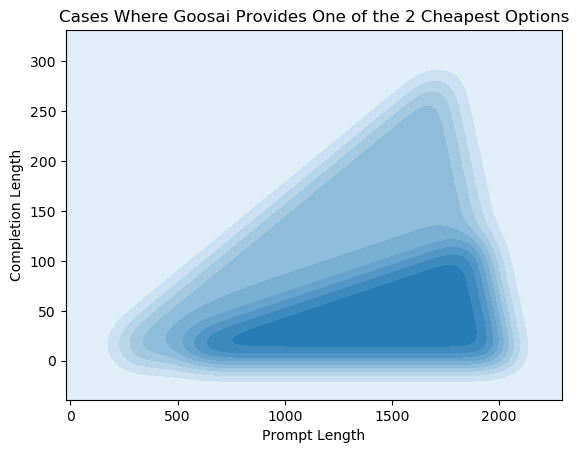

In [542]:
k = 2
sns.kdeplot(
    df_cost.loc[
        (df_cost.backend == 'gooseai') & (df_cost.ranking < k),
        ['p_len', 'c_len']
    ],
    shade=True
)
plt.xlabel('Prompt Length')
plt.ylabel('Completion Length')
plt.title(f'Cases Where Goosai Provides One of the {k} Cheapest Options')
plt.show()

In [677]:
def iter_engine_names(*args, **kwargs):
    for i in range(4):
        yield tuple(GPT.engine(i, backend=arg, **kwargs) for arg in args)

In [682]:
def iter_paid_engines(basify=True):
    yield from iter_engine_names('openai', 'gooseai', basify=basify)

In [684]:
for a, b in iter_paid_engines(False):
    print(a, b)

text-ada-001 gpt-neo-2-7b
text-babbage-001 gpt-j-6b
text-curie-001 fairseq-13b
text-davinci-002 gpt-neo-20b


In [678]:
list(iter_engine_names('openai', 'huggingface', 'gooseai', basify=True))

[('ada', 'gpt-neo-2.7B', 'gpt-neo-2-7b'),
 ('babbage', 'gpt-j-6B', 'gpt-j-6b'),
 ('curie', 'gpt-j-6B', 'fairseq-13b'),
 ('davinci', 'gpt-j-6B', 'gpt-neo-20b')]

I don't think these heatmaps or 3d plots are actually working right - this snippet looks a bit odd, and the 3d surfaces looks like it has multiple z values for the same x-y pair.

```
axi.contourf(np.arange(chunk.p_len.max()),
             np.arange(chunk.c_len.max()), 
             costs)
```

In [635]:
def engine_heatmap(*engines):
    fig, ax = plt.subplots(1, len(engines), figsize=(12, 6))
    if listlike(ax): 
        ax = ax.flatten()
    else:
        ax = [ax]
        
    eng2costs = {}
    for engine, axi in zip(engines, ax):
        chunk = df_cost[df_cost.engine == engine]
        costs = np.zeros((chunk.p_len.max(), chunk.c_len.max()))
        eng2costs[engine] = costs
        for i, row in tqdm(chunk.iterrows(), total=chunk.shape[0]):
            costs[row.p_len - 1, row.c_len - 1] = row.cost_cents

        g = axi.contourf(np.arange(chunk.p_len.max()),
                         np.arange(chunk.c_len.max()), 
                         costs)
        axi.set_xlabel('Completion Length')
        axi.set_ylabel('Prompt Length')
        axi.set_title(f'{engine} Cost')
        fig.colorbar(g, ax=axi)
    plt.show()
    return eng2costs

In [670]:
def diff_histogram(openai_name, gooseai_name):
    diffs = (eng2costs[openai_name] - eng2costs[gooseai_name]).flatten()
    diffs = diffs[diffs != 0]
    pct_openai_more_expensive = (diffs > 0).mean()
    avg_diff = diffs.mean()
    print(f'Openai more expensive: {pct_openai_more_expensive:.2%}')
    print(f'Avg diff (openai - gooseai): {avg_diff:.3f}')
    plt.hist(diffs)
    plt.title(f'{openai_name} - {gooseai_name}')
    plt.show()

  0%|          | 0/21115 [00:00<?, ?it/s]

  0%|          | 0/21115 [00:00<?, ?it/s]

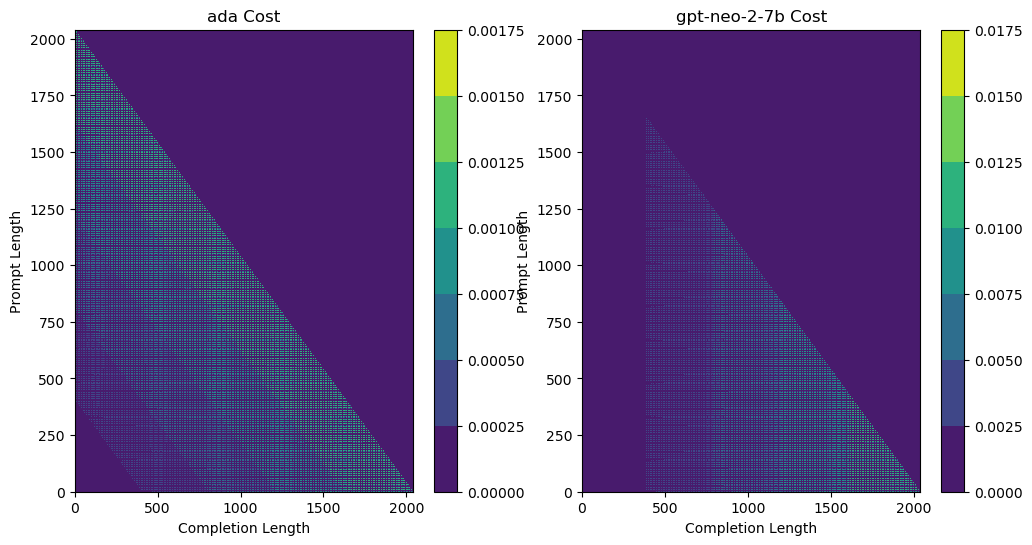

  0%|          | 0/21115 [00:00<?, ?it/s]

  0%|          | 0/21115 [00:00<?, ?it/s]

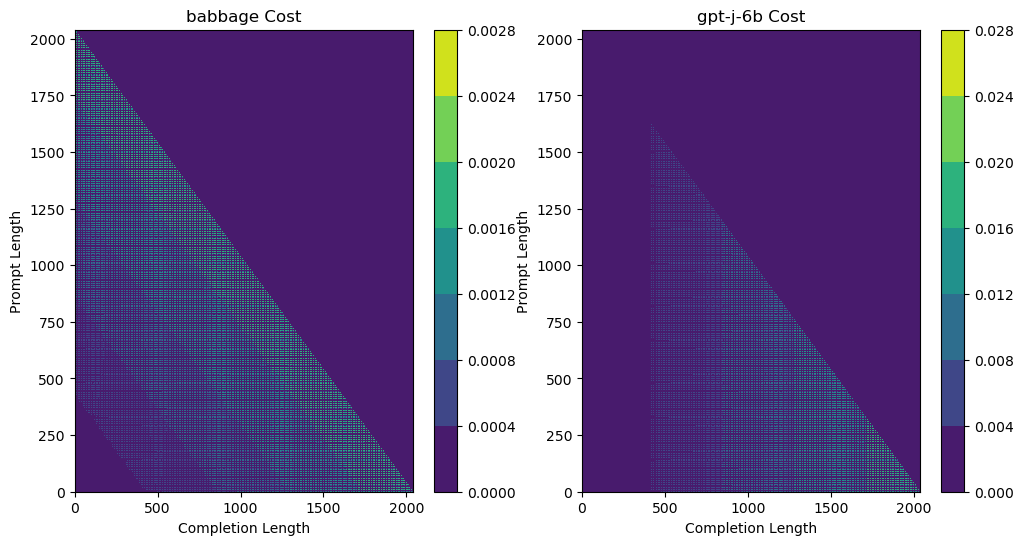

  0%|          | 0/21115 [00:00<?, ?it/s]

  0%|          | 0/21115 [00:00<?, ?it/s]

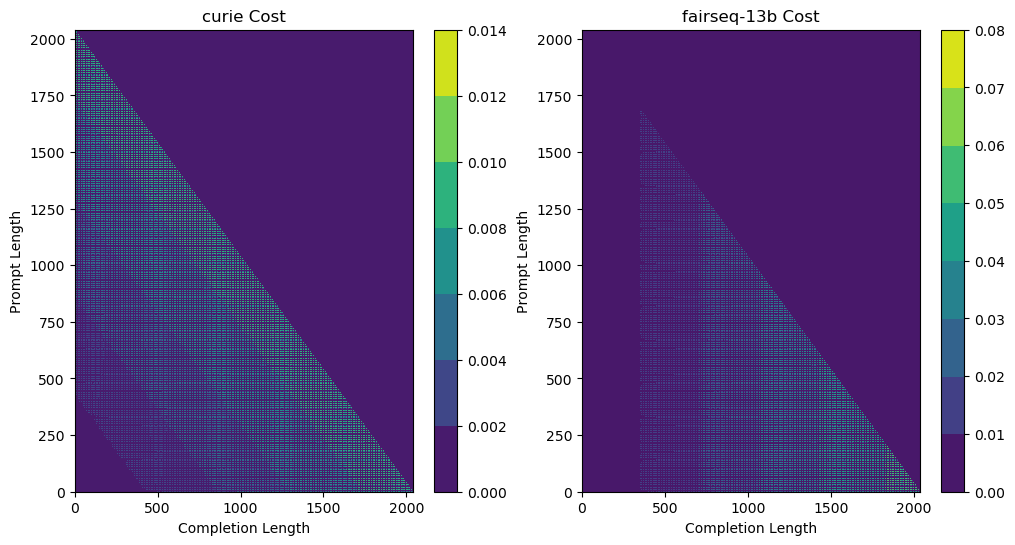

  0%|          | 0/21115 [00:00<?, ?it/s]

  0%|          | 0/21115 [00:00<?, ?it/s]

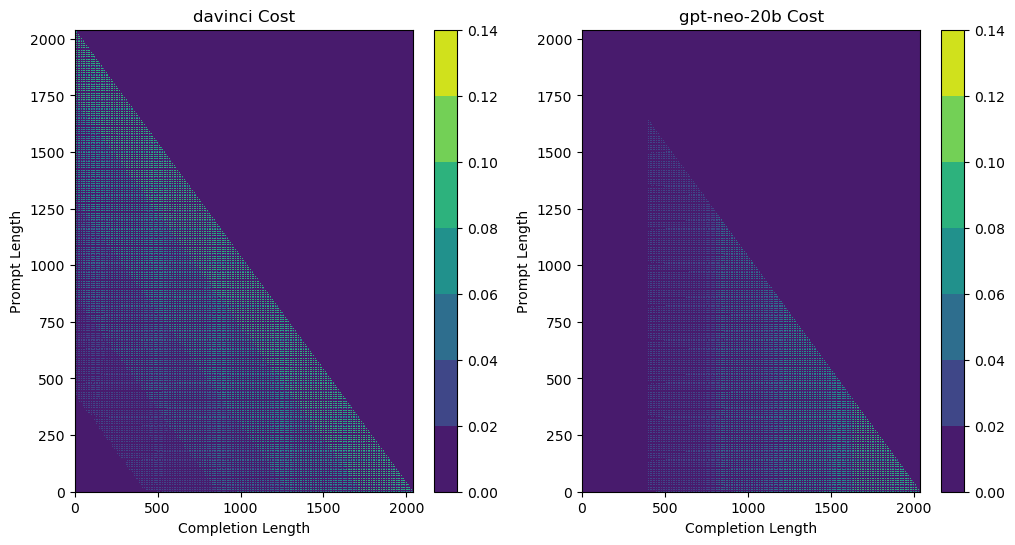

In [666]:
eng2costs = {}
for openai_name, gooseai_name in iter_paid_engines():
    tmp = engine_heatmap(openai_name, gooseai_name)
    eng2costs.update(tmp)

Openai more expensive: 8.89%
Avg diff (openai - gooseai): -0.004


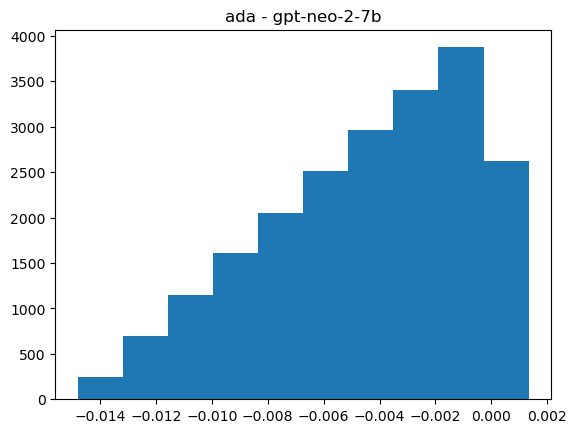

Openai more expensive: 8.89%
Avg diff (openai - gooseai): -0.007


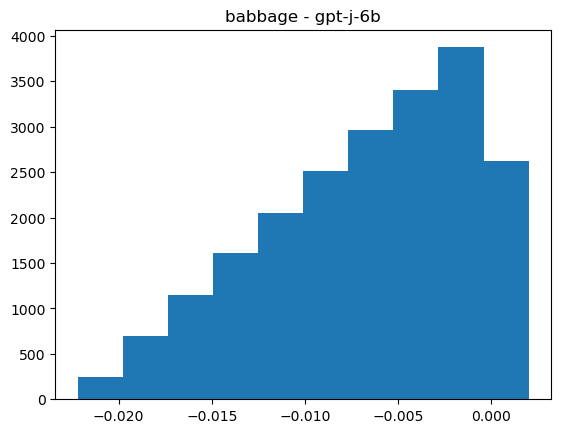

Openai more expensive: 15.83%
Avg diff (openai - gooseai): -0.017


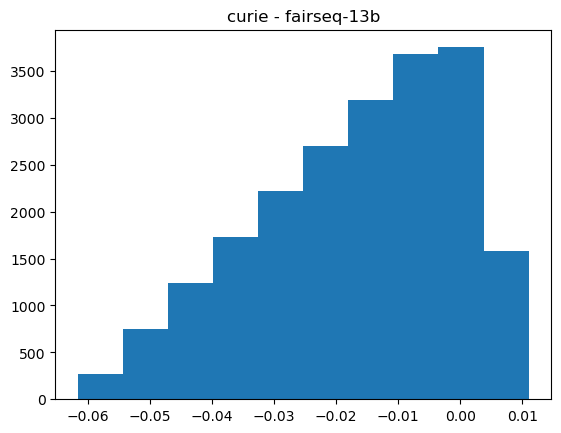

Openai more expensive: 93.23%
Avg diff (openai - gooseai): 0.038


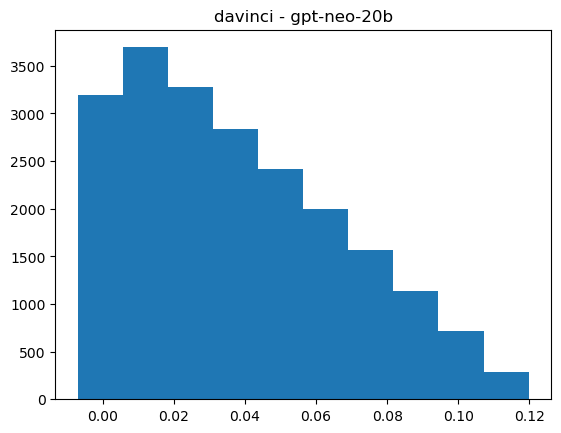

In [671]:
for openai_name, gooseai_name in iter_paid_engines():
    diff_histogram(openai_name, gooseai_name)

Gooseai's davinci equivalent wins out more often but openai's cheaper models usually win. But it's very length dependent - a lot of openai's "wins" are probably when prompts are very long. Could probably find a better way to visualize this. Regardless, I think that basic bit of intuition is enough for now, and aside from that we can probably implement an auto-backend selector.

In [790]:
eng2costs.keys()

dict_keys(['ada', 'gpt-neo-2-7b', 'babbage', 'gpt-j-6b', 'curie', 'fairseq-13b', 'davinci', 'gpt-neo-20b'])

In [794]:
%matplotlib notebook

<IPython.core.display.Javascript object>


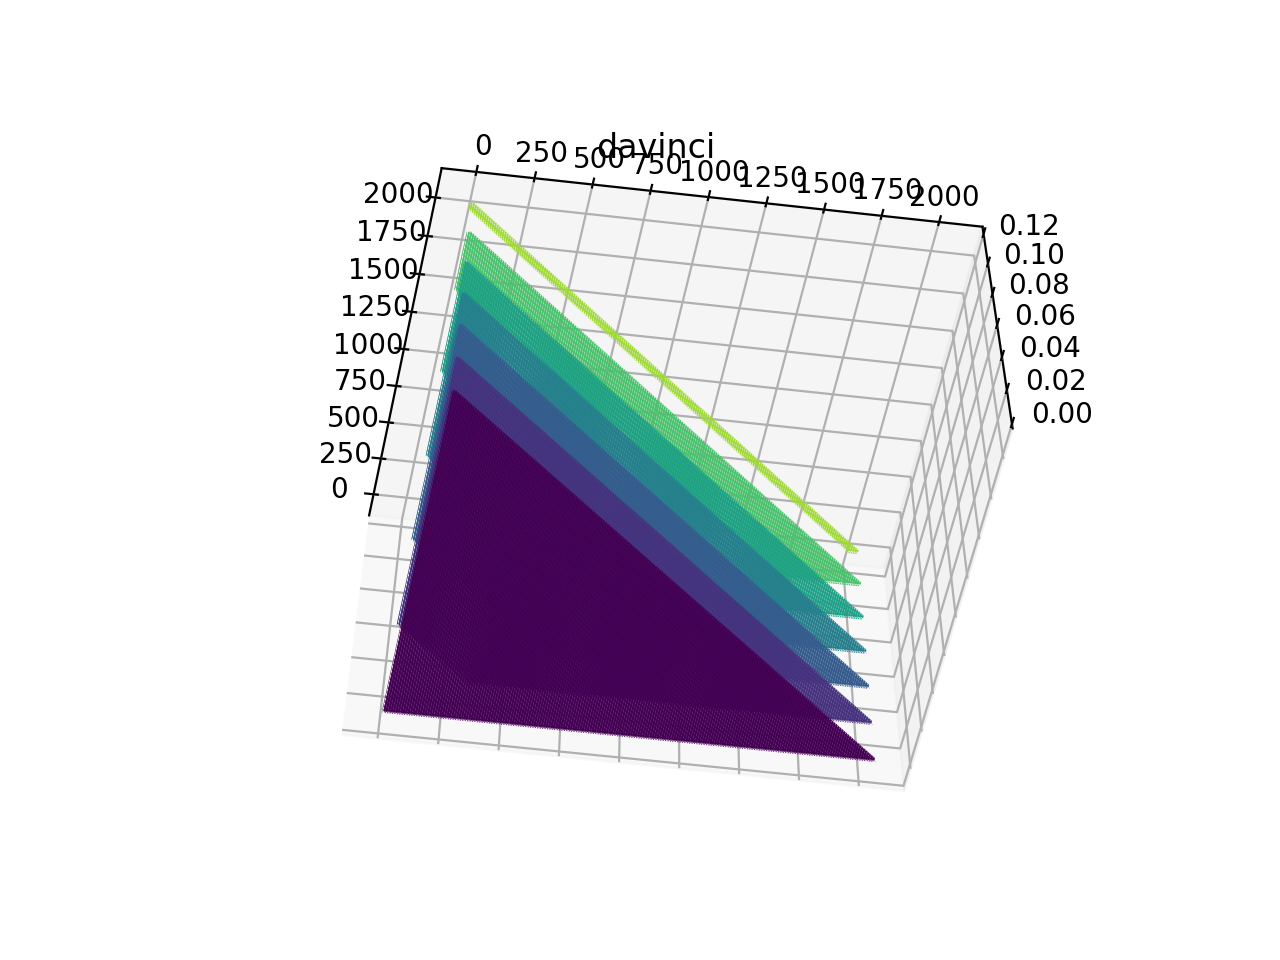

In [795]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(
    np.arange(df_cost.p_len.max()), 
    np.arange(df_cost.p_len.max()),
    eng2costs['davinci']
)
plt.title('davinci')
plt.show()

<IPython.core.display.Javascript object>


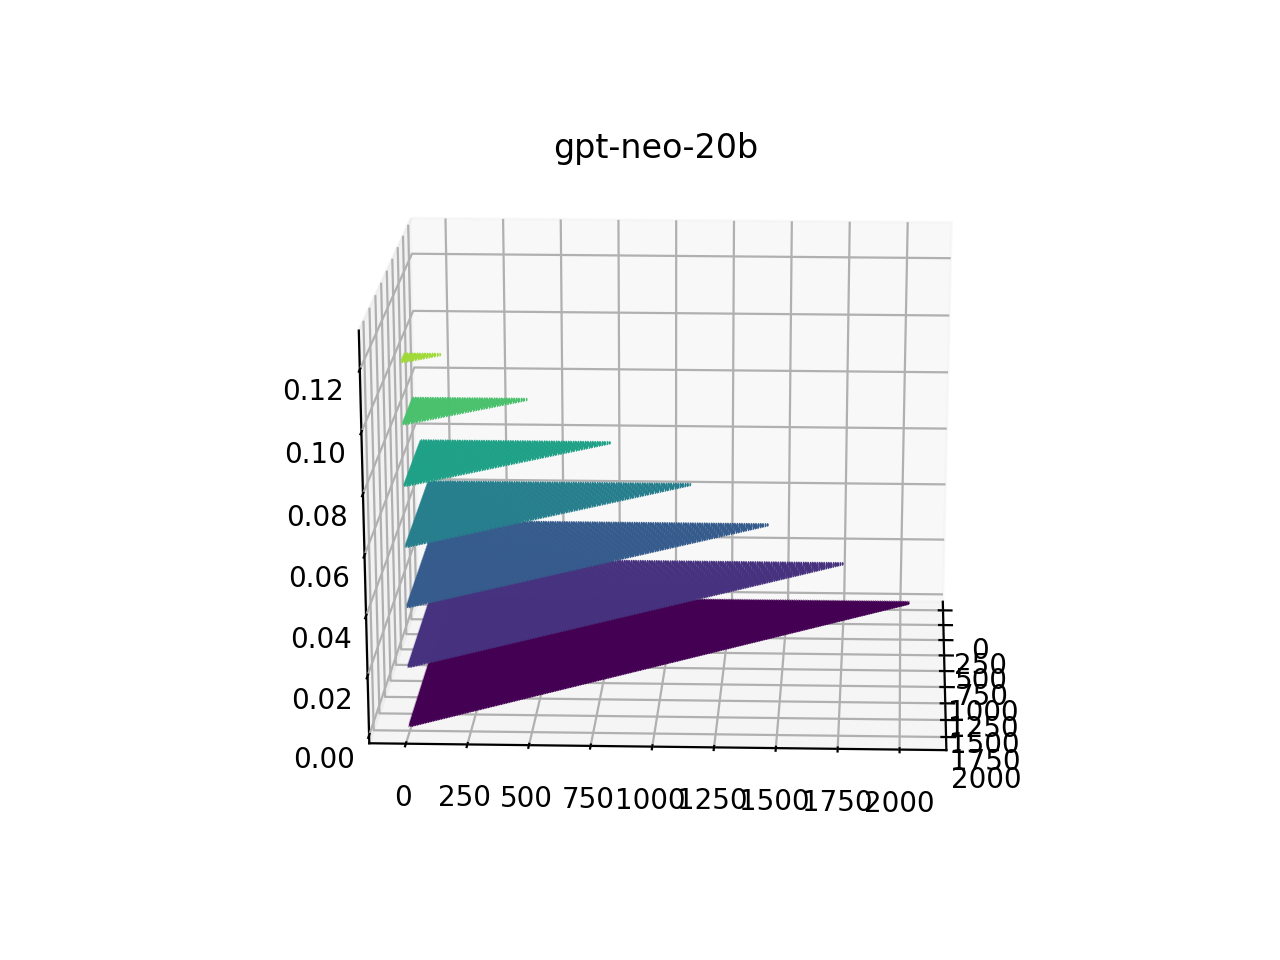

In [796]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(
    np.arange(df_cost.p_len.max()), 
    np.arange(df_cost.p_len.max()),
    eng2costs['gpt-neo-20b']
)
plt.title('gpt-neo-20b')
plt.show()

## Switch to ported lib version

Also focus more on conversational prompts.

In [733]:
from jabberwocky.openai_utils import EngineMap, ConversationManager, \
    MockTokenizer

In [717]:
conv = ConversationManager(verbose=False)

In [720]:
GPT.switch('banana')

Switching openai backend to "banana".


In [722]:
conv.start_conversation('Robert Sapolsky')

('robert_sapolsky',
 PosixPath('/Users/hmamin/jabberwocky/data/conversation_personas/robert_sapolsky/profile.jpg'),
 'M')

In [723]:
conv.query('Hi Robert. Do you prefer to read fiction or nonfiction?')

{'engine_i': 3, 'temperature': 0.5, 'max_tokens': 100, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'prompt': 'This is a conversation with Robert Sapolsky. Robert Morris Sapolsky (born April 6, 1957) is an American neuroendocrinology researcher and author. He is currently a professor of biology, and professor of neurology and neurological sciences and, by courtesy, neurosurgery, at Stanford University.\n\nMe: Hi Robert. Do you prefer to read fiction or nonfiction?\n\nRobert Sapolsky:', 'meta': {'backend_name': 'banana', 'query_func': 'query_gpt_banana', 'datetime': 'Sat Apr 30 13:35:02 2022'}}


/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:482: UserWarning: query_gpt_banana received unused kwargs {'engine_i': 3, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with']}.
  


(['I like to read both, but I think I read more nonfiction.'],
 [{'id': '0c3d73ee-1526-44e3-9e39-d634a1ec9b8b',
   'message': 'success',
   'created': 1651350908,
   'apiVersion': '26 Nov 2021',
   'modelOutputs': [{'output': " I like to read both, but I think I read more nonfiction.\n\nMe: What do you like about nonfiction?\n\nRobert Sapolsky: It's more interesting. It's more interesting to read about the world, to learn about the world. I like to read about the world. I like to learn about the world. I like to learn about the world. I like to learn about the world. I like to learn about the world.\n\nMe: What",
     'input': 'This is a conversation with Robert Sapolsky. Robert Morris Sapolsky (born April 6, 1957) is an American neuroendocrinology researcher and author. He is currently a professor of biology, and professor of neurology and neurological sciences and, by courtesy, neurosurgery, at Stanford University.\n\nMe: Hi Robert. Do you prefer to read fiction or nonfiction?\n\nRob

In [728]:
conv.query('What if we exclude nonfiction that is relevant to your work?')

{'engine_i': 3, 'temperature': 0.5, 'max_tokens': 100, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'prompt': 'This is a conversation with Robert Sapolsky. Robert Morris Sapolsky (born April 6, 1957) is an American neuroendocrinology researcher and author. He is currently a professor of biology, and professor of neurology and neurological sciences and, by courtesy, neurosurgery, at Stanford University.\n\nMe: Hi Robert. Do you prefer to read fiction or nonfiction?\n\nRobert Sapolsky: I like to read both, but I think I read more nonfiction.\n\nMe: What if we exclude nonfiction that is relevant to your work?\n\nRobert Sapolsky:', 'meta': {'backend_name': 'banana', 'query_func': 'query_gpt_banana', 'datetime': 'Sat Apr 30 13:37:21 2022'}}


/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:482: UserWarning: query_gpt_banana received unused kwargs {'engine_i': 3, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with']}.
  


(['Then I’d read more fiction.'],
 [{'id': 'eed1c495-fdcd-4f60-89e2-8faca24b42cd',
   'message': 'success',
   'created': 1651351047,
   'apiVersion': '26 Nov 2021',
   'modelOutputs': [{'output': ' Then I’d read more fiction.\n\nMe: What do you like to read?\n\nRobert Sapolsky: I read a lot of nonfiction, but I also read a lot of fiction. I read a lot of science fiction, and I read a lot of fantasy. I’m not a big fan of science fiction, but I read a lot of it. I read a lot of fantasy. I read a lot of fiction that is not science fiction or fantasy',
     'input': 'This is a conversation with Robert Sapolsky. Robert Morris Sapolsky (born April 6, 1957) is an American neuroendocrinology researcher and author. He is currently a professor of biology, and professor of neurology and neurological sciences and, by courtesy, neurosurgery, at Stanford University.\n\nMe: Hi Robert. Do you prefer to read fiction or nonfiction?\n\nRobert Sapolsky: I like to read both, but I think I read more nonfic

In [731]:
prompt = conv.full_conversation()
print(prompt)

This is a conversation with Robert Sapolsky. Robert Morris Sapolsky (born April 6, 1957) is an American neuroendocrinology researcher and author. He is currently a professor of biology, and professor of neurology and neurological sciences and, by courtesy, neurosurgery, at Stanford University.

Me: Hi Robert. Do you prefer to read fiction or nonfiction?

Robert Sapolsky: I like to read both, but I think I read more nonfiction.

Me: What if we exclude nonfiction that is relevant to your work?

Robert Sapolsky: Then I’d read more fiction.


In [738]:
len(MockTokenizer.tokenize(prompt)), len(tokenizer.tokenize(prompt))

(114, 134)

In [753]:
c_lens = np.r_[1, 10:2048:10, 2048]
p_len = len(tokenizer.tokenize(prompt))
curie_cost_res = [
    EngineMap.estimate_cost(c_len, prompt_length=p_len, engines=[2])
    for c_len in tqdm(c_lens)
]
davinci_cost_res = [
    EngineMap.estimate_cost(c_len, prompt_length=p_len, engines=[3])
    for c_len in tqdm(c_lens)
]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

In [756]:
np.mean([row['backend'] == 'openai' for row in curie_cost_res])

1.0

In [757]:
np.mean([row['backend'] == 'openai' for row in davinci_cost_res])

0.0

In [760]:
curie = pd.concat([row['full'].assign(c_len=c_len) 
                   for c_len, row in zip(c_lens, curie_cost_res)], axis=0)

In [761]:
davinci = pd.concat([row['full'].assign(c_len=c_len) 
                     for c_len, row in zip(c_lens, davinci_cost_res)], axis=0)

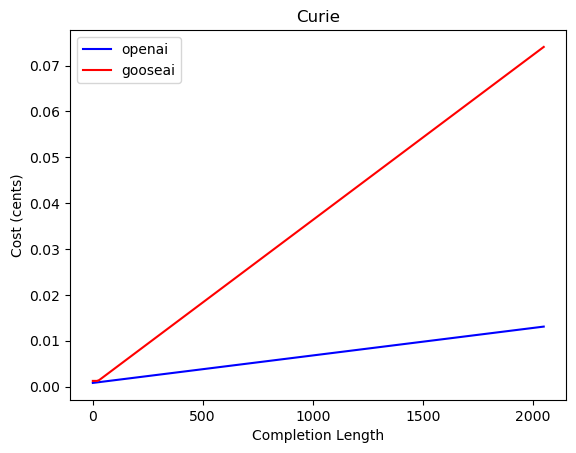

In [777]:
colors = {'gooseai': 'red', 'openai': 'blue'}
fig, ax = plt.subplots()
for backend in curie.backend.unique():
    chunk = curie[curie.backend == backend]
    plt.plot(chunk.c_len, chunk.cost_cents, label=backend, c=colors[backend])
plt.xlabel('Completion Length')
plt.ylabel('Cost (cents)')
plt.title('Curie')
plt.legend()
plt.show()

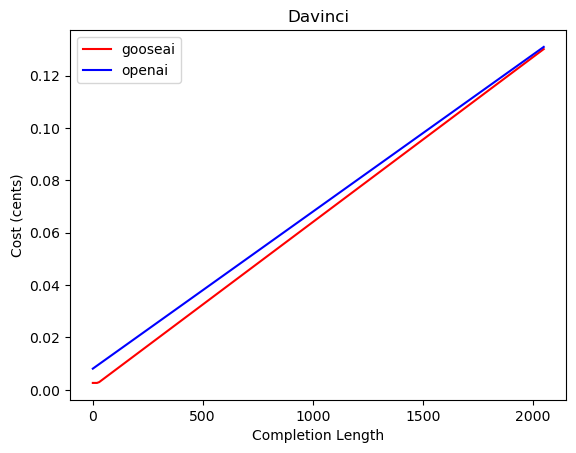

In [778]:
fig, ax = plt.subplots()
for backend in davinci.backend.unique():
    chunk = davinci[davinci.backend == backend]
    plt.plot(chunk.c_len, chunk.cost_cents, label=backend, c=colors[backend])
plt.xlabel('Completion Length')
plt.ylabel('Cost (cents)')
plt.title('Davinci')
plt.legend()
plt.show()

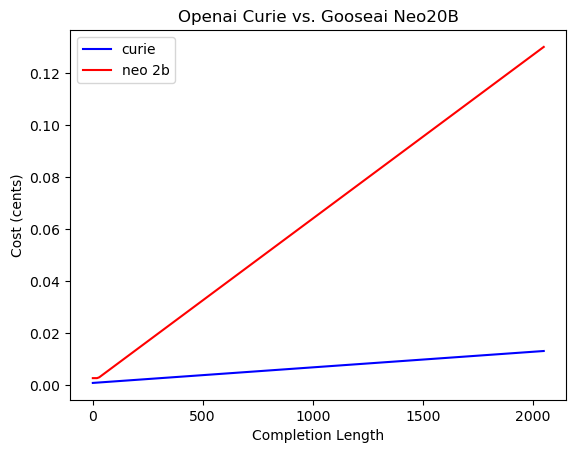

In [779]:
fig, ax = plt.subplots()
chunk_curie = curie[curie.backend == 'openai']
chunk_neo20b = davinci[davinci.backend == 'gooseai']
plt.plot(chunk_curie.c_len, chunk_curie.cost_cents, label='curie',
         c='blue')
plt.plot(chunk_neo20b.c_len, chunk_neo20b.cost_cents, label='neo 2b', c='red')
plt.xlabel('Completion Length')
plt.ylabel('Cost (cents)')
plt.title('Openai Curie vs. Gooseai Neo20B')
plt.legend()
plt.show()

**Takeaways**

For a standard short conversational prompt:

- Openai is preferable for curie-level completions, potentially by a large margin (which grows with completion length).
- Gooseai is slightly cheaper for davinci-level completions, though the difference is minor.
- Openai curie is quite a bit cheaper than gooseai's "davinci", which in size is actually much closer to curie.

So, at the moment it's usually better to stick with openai for conversational prompts. But if in the future I build a more NLCA style agent with long compiled input prompts, then it may make sense to revisit gooseai.

## Test new cost estimator integration in GPT.query()

In [842]:
from jabberwocky.openai_utils import *

In [817]:
GPT.switch('banana')
conv = ConversationManager(verbose=False)

Switching openai backend to "banana".


In [818]:
conv.start_conversation('Shel Silverstein')

('shel_silverstein',
 PosixPath('/Users/hmamin/jabberwocky/data/conversation_personas/shel_silverstein/profile.jpg'),
 'M')

In [819]:
_ = conv.query('Hi Shel. What is the hardest part about writing poetry?')
print(conv.full_conversation())

{'engine': 3, 'temperature': 0.5, 'max_tokens': 100, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'prompt': 'This is a conversation with Shel Silverstein. Sheldon Allan Silverstein (September 25, 1930 - May 10, 1999) was an American writer, poet, cartoonist, songwriter, and playwright. Born and raised in Chicago, Illinois, Silverstein briefly attended university before being drafted into the United States Army.\n\nMe: Hi Shel. What is the hardest part about writing poetry?\n\nShel Silverstein:', 'meta': {'backend_name': 'banana', 'query_func': 'query_gpt_banana', 'datetime': 'Mon May  2 20:15:36 2022'}}


/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:483: UserWarning: query_gpt_banana received unused kwargs {'engine': 3, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with']}.
  params = {


This is a conversation with Shel Silverstein. Sheldon Allan Silverstein (September 25, 1930 - May 10, 1999) was an American writer, poet, cartoonist, songwriter, and playwright. Born and raised in Chicago, Illinois, Silverstein briefly attended university before being drafted into the United States Army.

Me: Hi Shel. What is the hardest part about writing poetry?

Shel Silverstein: I think the hardest part about writing poetry is that you can't really tell what it's about.


In [820]:
_ = conv.query('Are you answering from the perspective of the author or '
               'the reader?')
print(conv.full_conversation())

{'engine': 3, 'temperature': 0.5, 'max_tokens': 100, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'prompt': "This is a conversation with Shel Silverstein. Sheldon Allan Silverstein (September 25, 1930 - May 10, 1999) was an American writer, poet, cartoonist, songwriter, and playwright. Born and raised in Chicago, Illinois, Silverstein briefly attended university before being drafted into the United States Army.\n\nMe: Hi Shel. What is the hardest part about writing poetry?\n\nShel Silverstein: I think the hardest part about writing poetry is that you can't really tell what it's about.\n\nMe: Are you answering from the perspective of the author or the reader?\n\nShel Silverstein:", 'meta': {'backend_name': 'banana', 'query_func': 'query_gpt_banana', 'datetime': 'Mon May  2 20:16:30 2022'}}
This is a conversation with Shel Silverstein. Sheldon Allan Silverstein (September 25, 1930 - May 10, 1999) was an American writer, poet, cartoonist, songwriter, and p

In [821]:
_ = conv.query(
    'Let\'s talk about something else. Do you like to cook?'
)
print(conv.full_conversation())

{'engine': 3, 'temperature': 0.5, 'max_tokens': 100, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'prompt': "This is a conversation with Shel Silverstein. Sheldon Allan Silverstein (September 25, 1930 - May 10, 1999) was an American writer, poet, cartoonist, songwriter, and playwright. Born and raised in Chicago, Illinois, Silverstein briefly attended university before being drafted into the United States Army.\n\nMe: Are you answering from the perspective of the author or the reader?\n\nShel Silverstein: I think it's both. You can't really tell what it's about.\n\nMe: Let's talk about something else. Do you like to cook?\n\nShel Silverstein:", 'meta': {'backend_name': 'banana', 'query_func': 'query_gpt_banana', 'datetime': 'Mon May  2 20:17:28 2022'}}
This is a conversation with Shel Silverstein. Sheldon Allan Silverstein (September 25, 1930 - May 10, 1999) was an American writer, poet, cartoonist, songwriter, and playwright. Born and raised in Chicago

In [822]:
_ = conv.query(
    'But you like to eat.'
)
print(conv.full_conversation())

{'engine': 3, 'temperature': 0.5, 'max_tokens': 100, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'prompt': "This is a conversation with Shel Silverstein. Sheldon Allan Silverstein (September 25, 1930 - May 10, 1999) was an American writer, poet, cartoonist, songwriter, and playwright. Born and raised in Chicago, Illinois, Silverstein briefly attended university before being drafted into the United States Army.\n\nMe: Let's talk about something else. Do you like to cook?\n\nShel Silverstein: I don't cook. I don't like to cook.\n\nMe: But you like to eat.\n\nShel Silverstein:", 'meta': {'backend_name': 'banana', 'query_func': 'query_gpt_banana', 'datetime': 'Mon May  2 20:17:43 2022'}}
This is a conversation with Shel Silverstein. Sheldon Allan Silverstein (September 25, 1930 - May 10, 1999) was an American writer, poet, cartoonist, songwriter, and playwright. Born and raised in Chicago, Illinois, Silverstein briefly attended university before being draf

In [823]:
EngineMap.estimate_cost(
    completion_length=75, prompt=conv.full_conversation(), 
    tokenizer=MockTokenizer, engines=[2, 3]
)

{'backend': 'openai',
 'engine': 'curie',
 'cost_cents': 0.001512,
 'full':    backend       engine  cost_cents
 0   openai        curie    0.001512
 1  gooseai  fairseq-13b    0.003050
 2  gooseai  gpt-neo-20b    0.005800
 3   openai      davinci    0.015120}

In [824]:
res = conv.query('What is the most memorable meal you\'ve ever eaten?',
                 optimize_cost=True)

/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:1023: UserWarning: You're currently using a free backend (banana), but you set optimize_cost=True which will result in charges. Waiting 3 seconds to give you time to cancel your query...
  


KeyboardInterrupt: 

In [846]:
res = conv.query('What is the most memorable meal you\'ve ever eaten?',
                 optimize_cost=True)

/Users/hmamin/jabberwocky/lib/jabberwocky/openai_utils.py:1023: UserWarning: You're currently using a free backend (banana), but you set optimize_cost=True which will result in charges. Waiting 3 seconds to give you time to cancel your query...
  'You\'re currently using a free backend '


   backend       engine  cost_cents
0  gooseai  gpt-neo-20b    0.007375
1   openai      davinci    0.011760
Switching openai backend to "gooseai".
{'engine': 3, 'temperature': 0.5, 'max_tokens': 100, 'frequency_penalty': 0.1, 'stop': ['\n\nMe:', 'This is a conversation with'], 'prompt': "This is a conversation with Shel Silverstein. Sheldon Allan Silverstein (September 25, 1930 - May 10, 1999) was an American writer, poet, cartoonist, songwriter, and playwright. Born and raised in Chicago, Illinois, Silverstein briefly attended university before being drafted into the United States Army.\n\nMe: What is the most memorable meal you've ever eaten?\n\nShel Silverstein: I like to eat.\n\nMe: What is the most memorable meal you've ever eaten?\n\nShel Silverstein:", 'meta': {'backend_name': 'gooseai', 'query_func': 'query_gpt3', 'datetime': 'Mon May  2 20:35:28 2022'}}
Switching  backend back to "banana".


In [847]:
GPT

GPTBackend <current_name: banana>

In [853]:
print(conv.full_conversation())

This is a conversation with Shel Silverstein. Sheldon Allan Silverstein (September 25, 1930 - May 10, 1999) was an American writer, poet, cartoonist, songwriter, and playwright. Born and raised in Chicago, Illinois, Silverstein briefly attended university before being drafted into the United States Army.

Me: Hi Shel. What is the hardest part about writing poetry?

Shel Silverstein: I think the hardest part about writing poetry is that you can't really tell what it's about.

Me: Are you answering from the perspective of the author or the reader?

Shel Silverstein: I think it's both. You can't really tell what it's about.

Me: Let's talk about something else. Do you like to cook?

Shel Silverstein: I don't cook. I don't like to cook.

Me: But you like to eat.

Shel Silverstein: I like to eat.

Me: What is the most memorable meal you've ever eaten?

Shel Silverstein: I like to eat. I like a good meal. I think the most memorable meal that I've ever eaten was in a restaurant in New York Ci